In [1]:
import imageio
import skimage
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

import kompressor as kom

### Load example image

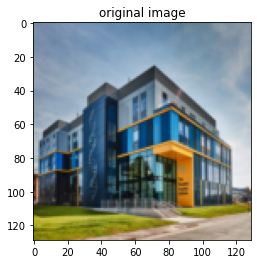

In [2]:
image = imageio.imread('data/building.jpg')
image = (skimage.transform.resize(image, (129, 129)) * 256.).astype(np.uint8)

plt.figure(figsize=(4,4), facecolor='w')
plt.title('original image')
plt.imshow(image)
plt.show()

### Select neighbourhood size for prediction model

In [3]:
padding = 1

# At padding=0 use neighbours [A-D] to predict values [0-4]

# AB    A2B
# CD    041
#       C3D

# At padding=1 use neighbours [A-P] to predict values [0-4]

# ABCD    A.B.C.D
# EFGH    .......
# IJKL    E.F2G.H
# MNOP    ..041..
#         I.J3K.L
#         .......
#         M.N.O.P

### Define a prediction model to generate maps

In [4]:
# Dummy regression predictor function just predicts the average of the neighborhood features
def predictions_fn(lowres):
    # lowres.shape == (B, H, W, C)

    # Extract the features for each neighborhood
    features = kom.image.features_from_lowres(lowres, padding)
    # features.shape == (B, H, W, N, C)
    # where N = ((padding * 2) + 1) ^ 2 is the number of surrounding neighbours included for this padding value

    # Dummy predictions are just the average values of the neighborhoods
    # << insert more intesting model here >>
    predictions = jnp.repeat(jnp.mean(features.astype(jnp.float32), axis=3, keepdims=True)
                             .astype(lowres.dtype), repeats=5, axis=3)
    # predictions.shape == (B, H, W, P, C)
    # where P = 5, the number of values that need to be predicted for each neighbourhood

    # Extract the maps from the predictions
    maps = kom.image.maps_from_predictions(predictions)
    # lrmap, udmap, cmap = maps
    # lrmap contains the merged right-pixel predictions of the neighbourhoods with the left-pixel predictions of the
    # adjacent neighbourhoods. The same is true in the udmap for up/down neighbourhoods. cmap requires no merging.
    # Number of pixels in the lowres, lrmap, udmap, and cmaps summed up equals the number of pixels in the highres image
    return maps

### Apply prediction model recursively to generate a pyramid of encoded maps

In [5]:
def plot_maps(title, highres, lowres, maps):

    fig, ax = plt.subplots(4, 4, figsize=(8, 9), facecolor='w')

    plt.suptitle(title)

    plt.sca(ax[0, 0])
    plt.title(f'highres {highres[0].shape}')
    plt.axis('off')
    plt.axis('equal')
    plt.imshow(highres[0])

    plt.sca(ax[1, 0])
    plt.title(f'lowres {lowres[0].shape}')
    plt.axis('off')
    plt.axis('equal')
    plt.imshow(lowres[0])

    plt.sca(ax[2, 0])
    plt.axis('off')

    plt.sca(ax[3, 0])
    plt.axis('off')

    for midx, (title, map) in enumerate(zip(['lrmap', 'udmap', 'cmap'], maps)):

        plt.sca(ax[0, midx+1])
        plt.title(f'{title} {map[0].shape}')

        bins = np.arange(257)
        for cidx, colour in enumerate('rgb'):
            plt.hist(np.array(map[0, ..., cidx]).flatten(), bins=bins, color=colour, histtype='step')

        for cidx, cmap in enumerate(['Reds', 'Greens', 'Blues']):

            plt.sca(ax[cidx+1, midx+1])
            plt.axis('off')
            plt.axis('equal')
            plt.imshow(map[0, ..., cidx], vmin=0, vmax=256, cmap=cmap)

    plt.tight_layout()
    plt.show()

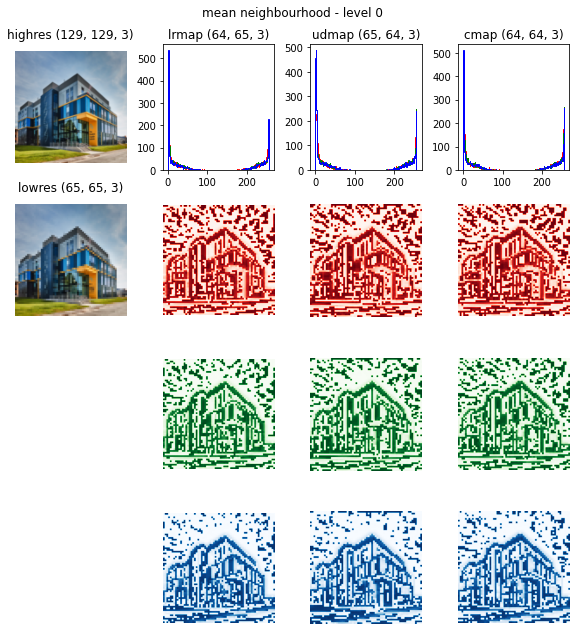

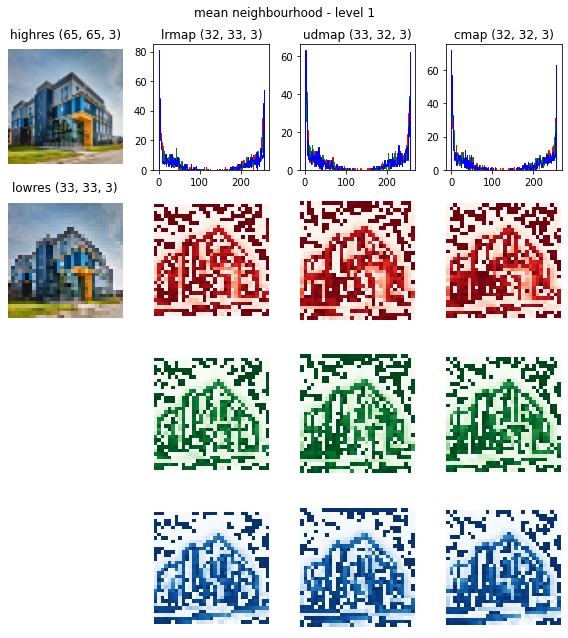

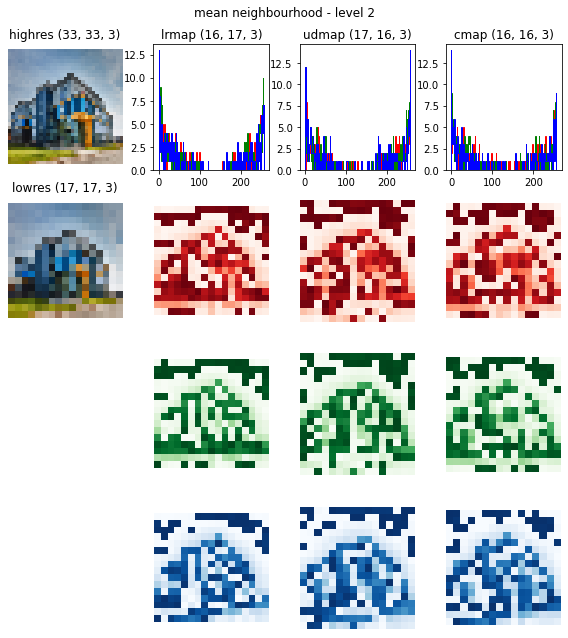

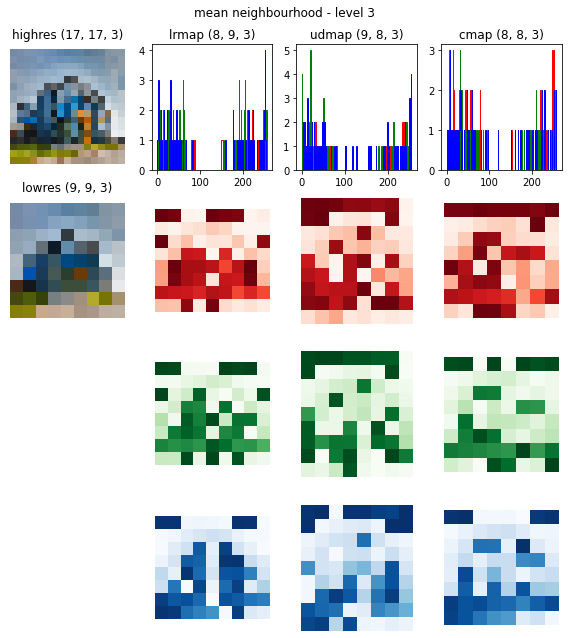

In [6]:
encode_fn = kom.image.encode_values_uint8
decode_fn = kom.image.decode_values_uint8

original_highres = jnp.array([image])
highres = jnp.array(original_highres)

encoded = list()

for level in range(4):
    lowres, (maps, dims) = kom.image.encode(predictions_fn, encode_fn, highres, padding=padding)
    encoded.append((maps, dims))
    plot_maps(f'mean neighbourhood - level {level}', highres, lowres, maps)
    highres = lowres

encoded_lowres = jnp.array(lowres)

### Combine smallest lowres image with stack of encoded maps to reconstruct highres image

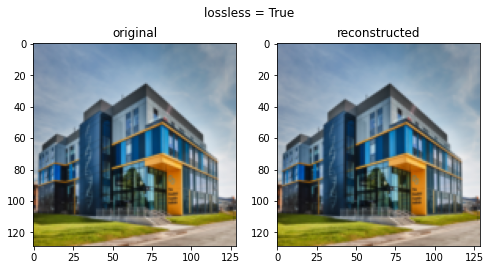

In [7]:
lowres = jnp.array(encoded_lowres)

for level, (maps, dims) in reversed(list(enumerate(encoded))):
    highres = kom.image.decode(predictions_fn, decode_fn, lowres, (maps, dims), padding=padding)
    lowres = highres

reconstructed_highres = jnp.array(highres)

fig, ax = plt.subplots(1, 2, figsize=(8,4), facecolor='w')

plt.suptitle(f'lossless = {np.allclose(original_highres[0], reconstructed_highres[0])}')

plt.sca(ax[0])
plt.title('original')
plt.imshow(original_highres[0])

plt.sca(ax[1])
plt.title('reconstructed')
plt.imshow(reconstructed_highres[0])

plt.show()